In [1]:
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model
import os
import h5py
import numpy as np
import sys
import interp_utils
from scipy.special import softmax
import seaborn as sns
from gopher import saliency_embed
import scipy.stats as stats
sys.path.append('../data_generation/')
import utils
import pickle as pkl
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

count = 3

/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mask_seq_by_token(top_x,tokenizer):
    """Mask every token by order for prediction of the loci"""
    seq = utils.onehot_to_seq(top_x)
    token_seq = tokenizer.batch_tokenize(seq)
    token_id = [b[1] for b in token_seq]
    m_seq_list = []
    for s in token_id:
        for loc in range(len(token_id[0])):
            m_seq = np.copy(s)
            m_seq[loc] = tokenizer.mask_token_id
            m_seq_list.append(m_seq)
    m_seq_list = np.array(m_seq_list)

    return m_seq_list

def pred_matrix(forward_fn,m_seq_list):
    N,L = m_seq_list.shape
    random_key = jax.random.PRNGKey(0)
    logit_matrix = np.zeros((N//L,L,4105))
    for i in range(N//L):
        batch = jnp.asarray(m_seq_list[i*L:(i+1)*L],dtype=jnp.int32)
        output = forward_fn.apply(parameters, random_key, batch)['logits']
        for loc in range(L):
            logit_matrix[i,loc] = output[loc,loc,:]
    p_matrix = softmax(logit_matrix,axis=-1)
    entrophy = stats.entropy(p_matrix,axis=-1)

    return p_matrix,entrophy

def plot_max_kmer(tokenizer,p_matrix):
    #Most likly k-mer plotting
    max_kmer_id = np.argmax(p_matrix,axis=-1)
    max_p = np.max(p_matrix,axis = -1)

    max_kmer = []
    full_p = []
    for i in range(max_kmer_id.shape[0]):
        kmer_list = []
        p_list = []
        for loc in range(max_kmer_id.shape[1]):
            token = tokenizer.id_to_token(max_kmer_id[i,loc])
            kmer_list.append(token)
            p_list.extend([max_p[i,loc]]*len(token))
        max_kmer.append(''.join(kmer_list[1:]))
        full_p.append(np.array(p_list[5:]))
        if len(max_kmer[-1]) != len(full_p[-1]):
            print(len(max_kmer[-1]))
            print(len(full_p[-1]))

    max_onehot = []
    for s in max_kmer:
        max_onehot.append(utils.seq_to_onehot(s))
    interp_utils.plot_entropy_per_loc(max_onehot,full_p)

def plot_entropy(top_x,entropy):
    ## Entrophy plotting
    kmer_l = top_x.shape[1]//6
    single_l = top_x.shape[1]%6
    kmer_e = entropy[:,1:1+kmer_l]
    single_e = entropy[:,-single_l:]
    full_e = np.repeat(kmer_e, 6,axis=-1)
    full_e = np.append(full_e,single_e,axis=-1)
    reverse_e = np.max(full_e) - full_e
    # reverse_e = 12 - full_e
    interp_utils.plot_entropy_per_loc(top_x,reverse_e)

def embed_saliency(model_path,forward_fn,tokenizer,top_x,binary=True):
    sequence = utils.onehot_to_seq(top_x)
    token_out = tokenizer.batch_tokenize(sequence)
    token_id = [b[1] for b in token_out]
    
    random_key = jax.random.PRNGKey(0)
    batch = jnp.asarray(token_id,dtype=jnp.int32)
    embed = forward_fn.apply(parameters, random_key, batch)['embeddings_10']
    
    model = tf.keras.models.load_model(model_path)
    if binary:
        input_layer = model.input 
        logit_layer = model.layers[-2].output
        model = tf.keras.models.Model(input_layer,logit_layer)

    explainer = saliency_embed.Explainer(model, class_index=0,binary = True)
    saliency_scores = explainer.saliency_maps(embed)
    l2_saliency = np.linalg.norm(saliency_scores,axis=-1)

    del(model)
    del(embed)
    tf.keras.backend.clear_session()
    return l2_saliency

def mutiply_cnn_saliency(top_x,entropy,saliency,plot_count=None): 
    reverse_e = np.max(entropy) - entropy
    sal_e = np.array([e*s for e,s in zip(reverse_e,saliency)])
    
    kmer_l = top_x.shape[1]//6
    single_l = top_x.shape[1]%6
    kmer_e = sal_e[:,1:1+kmer_l]
    single_e = sal_e[:,-single_l:]
    full_e = np.repeat(kmer_e, 6,axis=-1)
    full_e = np.append(full_e,single_e,axis=-1)
    
    # reverse_e = 12 - full_e
    if plot_count is not None:
        interp_utils.plot_value_per_loc(top_x[:plot_count],full_e[:plot_count])
    
    return full_e

## CHIP

In [3]:
exp = 'CTCF'

top_x = np.load('./top_seq/chip/'+exp+'.npz')['arr_0']
datalen = top_x.shape[1]

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name="2B5_1000G",
    embeddings_layers_to_save=(10,),
    max_positions=datalen//6 + datalen%6 + 1,
)
forward_fn = hk.transform(forward_fn)

In [4]:
## Make predictions with NT model
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = pred_matrix(forward_fn,m_seq_list)

/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


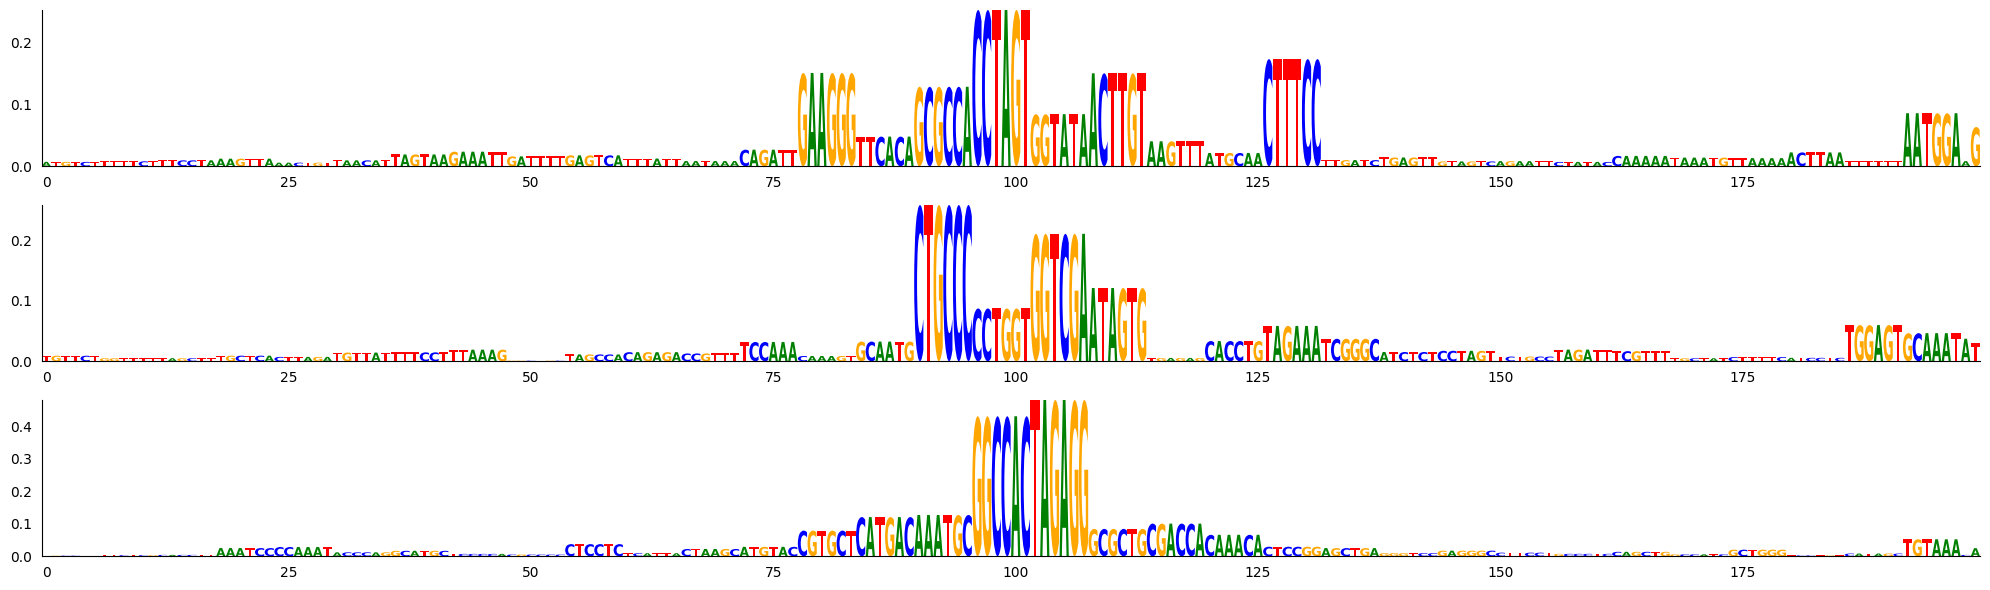

In [5]:
saliency = embed_saliency('/home/ztang/LLM_eval/model/chip_model/chip_NT/10_'+exp+'.h5'
                        ,forward_fn,tokenizer,top_x)
full_e = mutiply_cnn_saliency(top_x,entropy,saliency,count)
np.savez('./top_saliency/NT_chip_'+exp+'.npz',arr_1 = full_e)

## INSERT

In [9]:
top_x = np.load('./top_seq/insert.npz')['arr_0']
datalen = top_x.shape[1]

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name="2B5_1000G",
    embeddings_layers_to_save=(10,),
    max_positions=datalen//6 + datalen%6 + 1,
)
forward_fn = hk.transform(forward_fn)

In [10]:
## Make predictions with NT model
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = pred_matrix(forward_fn,m_seq_list)

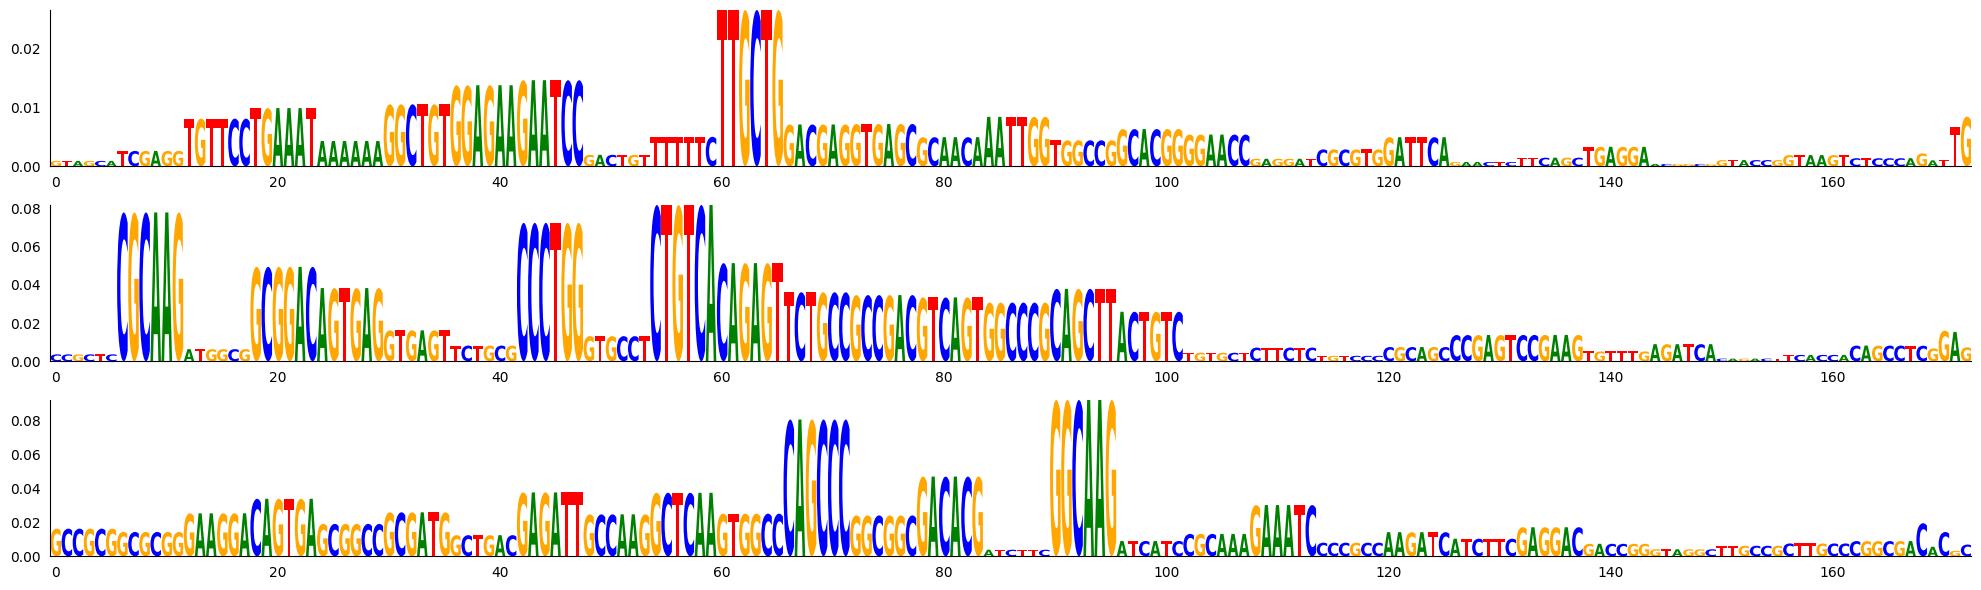

: 

In [11]:
saliency = embed_saliency('/home/ztang/LLM_eval/model/RNAenlong/NT.h5'
                        ,forward_fn,tokenizer,top_x,False)
full_e = mutiply_cnn_saliency(top_x,entropy,saliency,count)
np.savez('./top_saliency/NT_insert.npz',arr_1 = full_e)

## Lenti

In [6]:
from sklearn import model_selection
ct = 'K562'
top_x = np.load('./top_seq/lenti_'+ct+'.npz')['arr_0']
datalen = top_x.shape[1]

parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name="2B5_1000G",
    embeddings_layers_to_save=(10,),
    max_positions=datalen//6 + datalen%6 + 1,
)
forward_fn = hk.transform(forward_fn)

In [7]:
## Make predictions with NT model
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = pred_matrix(forward_fn,m_seq_list)

/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


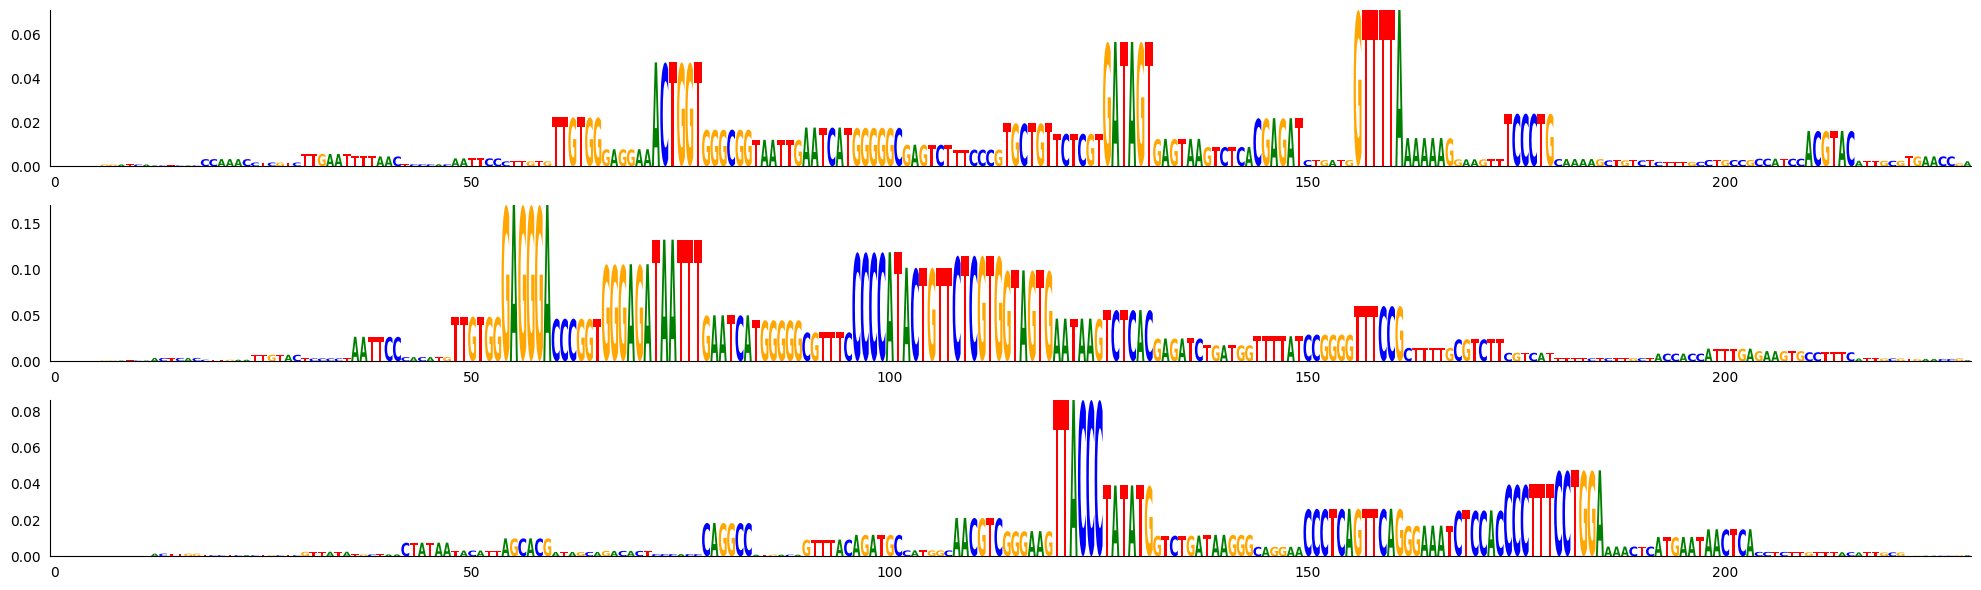

In [8]:
saliency = embed_saliency('/home/ztang/LLM_eval/model/lenti_MPRA/lenti_MPRA_embed/'+ct+'/layer_10.h5'
                        ,forward_fn,tokenizer,top_x,False)
full_e = mutiply_cnn_saliency(top_x,entropy,saliency,count)
np.savez('./top_saliency/NT_lenti_'+ct+'.npz',arr_1 = full_e)

## CLIP

In [13]:
# eClip CNN
exp = 'TIA1'
top_x = np.load('./top_seq/clip/'+exp+'.npz')['arr_0']
datalen = top_x.shape[1]

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name="2B5_1000G",
    embeddings_layers_to_save=(10,),
    max_positions=datalen//6 + datalen%6 + 1,
)
forward_fn = hk.transform(forward_fn)

In [14]:
## Make predictions with NT model
m_seq_list = mask_seq_by_token(top_x,tokenizer)
p_matrix,entropy = pred_matrix(forward_fn,m_seq_list)

/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


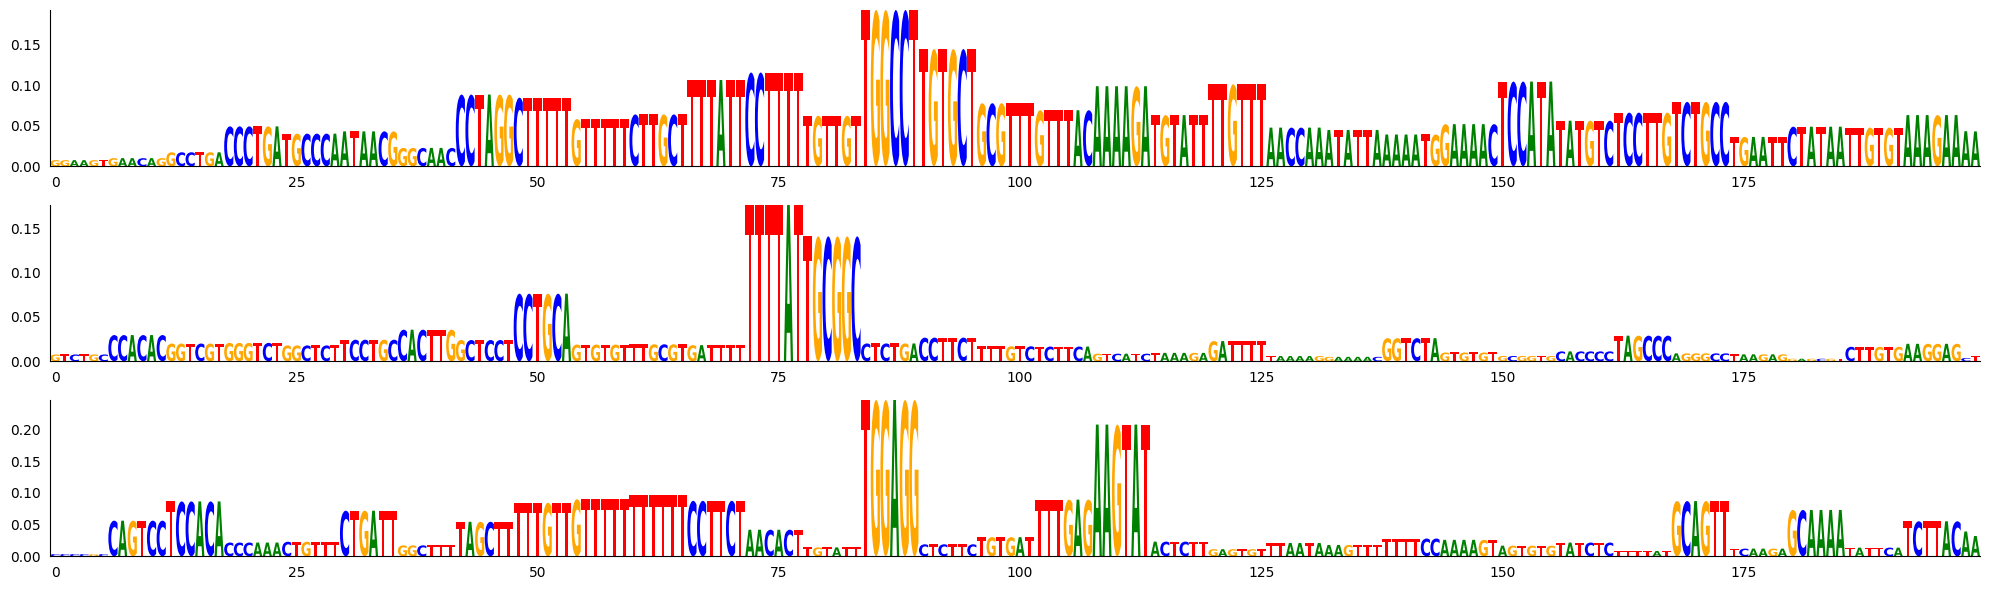

: 

In [15]:
saliency = embed_saliency('/home/ztang/LLM_eval/model/clip_model/eclip_NT/10_'+exp+'.h5'
                        ,forward_fn,tokenizer,top_x)
full_e = mutiply_cnn_saliency(top_x,entropy,saliency,count)
np.savez('./top_saliency/NT_clip_'+exp+'.npz',arr_1 = full_e)